In [15]:
import gymnasium as gym
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [16]:
#creación del entorno
env = gym.make("FrozenLake-v1",desc=["SF", "FG"], is_slippery=False, render_mode="human")
#Acciones
action_names = {0:'Arriba', 1:'Abajo', 2:'Derecha',3:'Izquierda'}

print('Número de estados: ', env.observation_space)
# acciones: izquierda = 0, abajo = 1, derecha = 2 y arriba = 3
print('Número de acciones: ', env.action_space)

Número de estados:  Discrete(4)
Número de acciones:  Discrete(4)


In [17]:
env.unwrapped.P = {
    0: {  # Estado A
        0: [(1.0, 0, -1, False)],                     # arriba → se queda en A
        1: [(0.8, 2, -1, False), (0.2, 0, -1, False)], # abajo → C
        2: [(0.8, 1, -1, False), (0.2, 0, -1, False)], # derecha → B
        3: [(1.0, 0, -1, False)]                      # izquierda → se queda en A
    },
    1: {  # Estado B
        0: [(1.0, 1, -1, False)],                     
        1: [(0.8, 3, 10, True), (0.2, 1, -1, False)],  # abajo → D (terminal)
        2: [(1.0, 1, -1, False)],                     
        3: [(0.8, 0, -1, False), (0.2, 1, -1, False)]
    },
    2: {  # Estado C
        0: [(0.8, 0, -1, False), (0.2, 2, -1, False)],
        1: [(1.0, 2, -1, False)],                     
        2: [(0.8, 3, 10, True), (0.2, 2, -1, False)],  # derecha → D (terminal)
        3: [(1.0, 2, -1, False)]
    },
    3: {  # Estado D
        0: [(1.0, 3, 0, True)],
        1: [(1.0, 3, 0, True)],
        2: [(1.0, 3, 0, True)],
        3: [(1.0, 3, 0, True)]
    }
}

In [18]:
# La salida es una lista, donde cada entrada representa una de las acciones probables dada la acción elegida con las siguientes variables:
# (probabilidad de transición, siguiente estado, recompensa, ¿Es un estado terminal?)
env.unwrapped.P[1][1] #(estado actual, acción elegida)

[(0.8, 3, 10, True), (0.2, 1, -1, False)]

In [19]:
def policy_evaluation(env, policy_vec, val_fun_vec, conv_tolerance, discount=0.9):
    """Evaluación de la política"""
    while True:
        delta = 0
        for state in env.unwrapped.P:
            prev_val = val_fun_vec[state]
            #Cálculo del retorno esperando
            expected_return = sum([prob*(reward + discount*val_fun_vec[next_state]) 
                                      for prob,next_state,reward,is_terminal_state 
                                      in env.unwrapped.P[state][policy_vec[state]]])
            #Actualización de los valores
            val_fun_vec[state] = expected_return
            #Actualización de delta
            delta = np.max([delta, np.abs(prev_val - val_fun_vec[state])])

        if(delta < conv_tolerance):
            return policy_vec, val_fun_vec, delta

In [20]:
def policy_improvement(policy_vec, val_fun_vec, policy_stable_vec, discount=0.9):
    """Mejoramiento de la política"""
    for state in env.unwrapped.P:
        old_action = policy_vec[state]
        #Cálculo de los valores de acción
        action_values = np.zeros(env.action_space.n)
        for action_p in env.unwrapped.P[state]:
            action_values[action_p] = sum([prob*(reward + discount*val_fun_vec[next_state]) 
                                           for prob, next_state, reward, is_terminal_state 
                                           in env.unwrapped.P[state][action_p]])
        #Acción de mayor valor
        policy_vec[state] = np.argmax(action_values)
        
        if old_action == policy_vec[state]:
            policy_stable_vec[state] = True
            
    return policy_vec, policy_stable_vec

In [21]:
def policy_iteration(env, discount = 0.9, conv_tolerance=1e-4, max_iterations=100):
    """Algoritmo de iteración de política"""
    #Vector de estabilidad
    policy_stable_vec = np.zeros(env.observation_space.n, dtype=bool)
    #Función de valor
    val_fun_vec = np.zeros(env.observation_space.n)
    #Política
    policy_vec = np.ones(env.observation_space.n, dtype=int)
    for iterations in range(max_iterations):
        #Evaluación de política
        policy_vec, val_fun_vec, delta = policy_evaluation(env, policy_vec, val_fun_vec, 
                                                                       conv_tolerance, discount=discount)
        #Mejoramiento de la política
        policy_vec, policy_stable_vec = policy_improvement(policy_vec, val_fun_vec, policy_stable_vec, 
                                                           discount=discount)
        
        if np.all(policy_stable_vec == True):
            return policy_vec, val_fun_vec

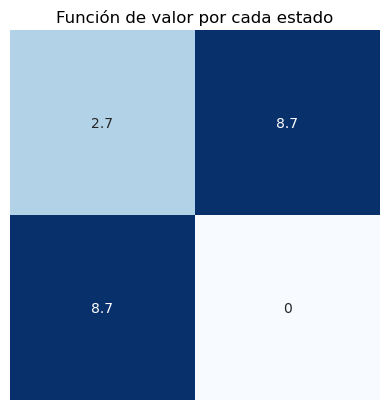

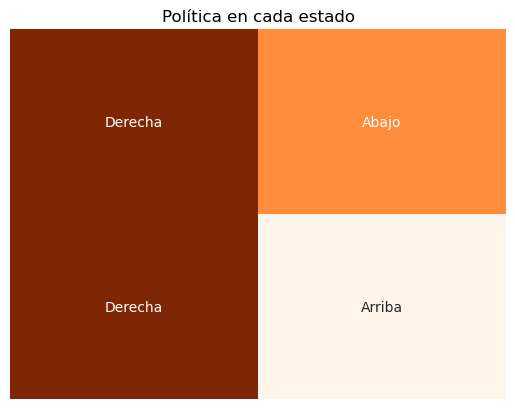

In [22]:
#ejecución del algoritmo de policy iteration
policy_vec, val_fun_vec = policy_iteration(env, discount=0.5)

def values_print(valueFunction,reshapeDim=2):
    ax = sns.heatmap(valueFunction.reshape(reshapeDim,reshapeDim),annot=True, square=True,cbar=False, 
                     cmap='Blues',xticklabels=False, yticklabels=False)
    plt.title('Función de valor por cada estado')
    plt.show()

def actions_print(policy_vec,reshapeDim=2):
    ax = sns.heatmap(policy_vec.reshape(reshapeDim,reshapeDim),annot=np.array([action_names[a] for a in policy_vec]).reshape(reshapeDim,reshapeDim), 
                     fmt='',cbar=False, cmap='Oranges',xticklabels=False, yticklabels=False)
    plt.title('Política en cada estado')
    plt.show()

values_print(val_fun_vec)
actions_print(policy_vec)

In [23]:
env.reset()
n_episodes_t = 2
for e in range(1, n_episodes_t+1):
    current_state = env.reset()[0]
    done = False
    score = 0
    actions = []
    while done == False:
        #Acción ambiciosa
        action = policy_vec[current_state]
        actions.append(action_names[action])
        #Se obtienen los resultados del ambiente por la acción elegida
        state, reward, done, _,_= env.step(action)
        score += reward
        #Se transita al nuevo estado
        current_state = state

    print('Episodio: {}\n\tAcciones: {};\n\tPuntaje: {}'.format(e, actions, score))
    
env.close()

Episodio: 1
	Acciones: ['Derecha', 'Abajo'];
	Puntaje: 9
Episodio: 2
	Acciones: ['Derecha', 'Abajo'];
	Puntaje: 9
